Transfer Learning With Tensorflow for Images
We are going to train a model to identify cats and dogs from the image.

Pipeline
1. Import all the required modules
2. Download the dataset
3. Load the dataset into memory
4. Preprocess the data
5. Import Mobilenet V2 imagenet model
6. Configure the model
7. Train the model
8. Plot the graphs for Traininig and Validation
9. Perform Fine tuning
10. Retrain the model
11. Plot graphs for training and inference.

Import all the required modules

In [1]:
#Author: Sumedh Vilas Datar
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

Download the dataset containing Cats and Dogs 

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip' #Download from the URL
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True) #If the dataset is already available , just add the path
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

68616192/68606236 [==============================] - 1s 0us/step


Load the dataset into Memory in Batches

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Display Few Images and Visually See the Images

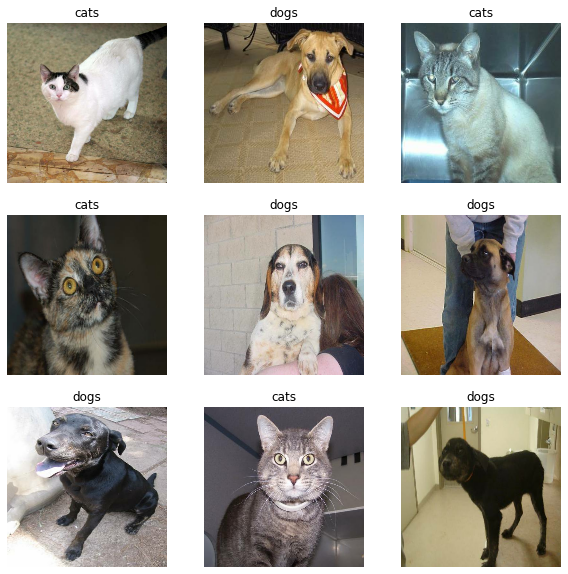

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Perform Data Augmentation to generate more varied data

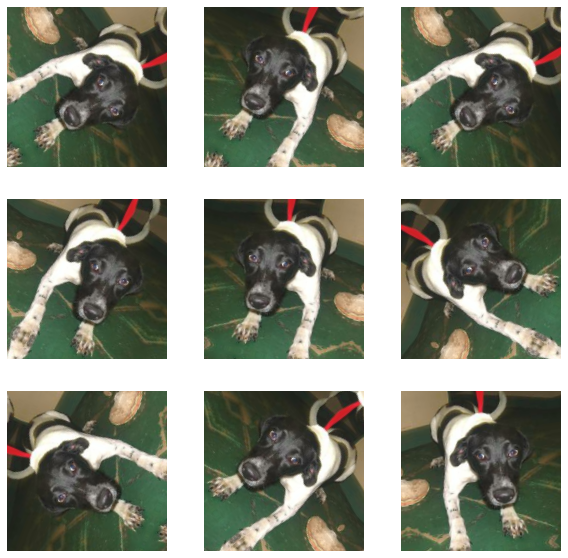

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Pre-process the data

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False


9420800/9406464 [==============================] - 0s 0us/step
(32, 5, 5, 1280)


In [9]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Attaching a custom layer which flattens the previous layer and attaches a new classfier head.

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


Defining the entire model architecture

In [11]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compiling the model

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

Training the new model

In [13]:
epochs = 5
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/5
63/63 [==============================] - 51s 762ms/step - loss: 0.6480 - accuracy: 0.6200 - val_loss: 0.5069 - val_accuracy: 0.7005
Epoch 2/5
63/63 [==============================] - 50s 790ms/step - loss: 0.4808 - accuracy: 0.7460 - val_loss: 0.3827 - val_accuracy: 0.7896
Epoch 3/5
63/63 [==============================] - 48s 755ms/step - loss: 0.3939 - accuracy: 0.8110 - val_loss: 0.2990 - val_accuracy: 0.8428
Epoch 4/5
63/63 [==============================] - 49s 771ms/step - loss: 0.3306 - accuracy: 0.8455 - val_loss: 0.2477 - val_accuracy: 0.8787
Epoch 5/5
63/63 [==============================] - 49s 776ms/step - loss: 0.2997 - accuracy: 0.8685 - val_loss: 0.2111 - val_accuracy: 0.9047


Plotting the graph to see the model performance

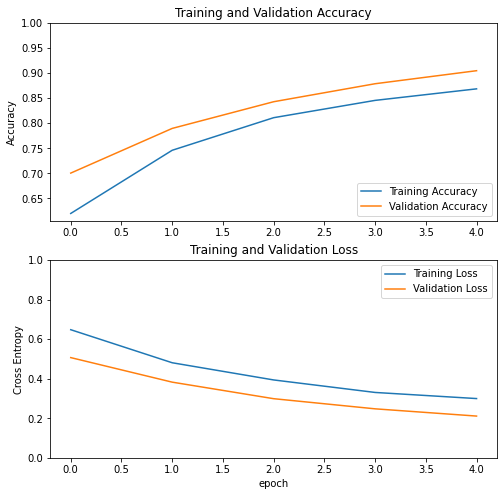

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
#To fine tune the model we have to change the mode for the base model

base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


Recompile the new model

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

Training the fine tuned model

In [17]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/15
63/63 [==============================] - 79s 1s/step - loss: 0.1692 - accuracy: 0.9260 - val_loss: 0.0602 - val_accuracy: 0.9802
Epoch 6/15
63/63 [==============================] - 72s 1s/step - loss: 0.1221 - accuracy: 0.9490 - val_loss: 0.0534 - val_accuracy: 0.9790
Epoch 7/15
63/63 [==============================] - 73s 1s/step - loss: 0.1139 - accuracy: 0.9500 - val_loss: 0.0461 - val_accuracy: 0.9839
Epoch 8/15
63/63 [==============================] - 71s 1s/step - loss: 0.1109 - accuracy: 0.9560 - val_loss: 0.0459 - val_accuracy: 0.9790
Epoch 9/15
63/63 [==============================] - 71s 1s/step - loss: 0.0990 - accuracy: 0.9630 - val_loss: 0.0518 - val_accuracy: 0.9765
Epoch 10/15
63/63 [==============================] - 73s 1s/step - loss: 0.0942 - accuracy: 0.9570 - val_loss: 0.0431 - val_accuracy: 0.9802
Epoch 11/15
63/63 [==============================] - 72s 1s/step - loss: 0.0831 - accuracy: 0.9700 - val_loss: 0.0517 - val_accuracy: 0.9777
Epoch 12/15
63/63 

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

Plot the graph for the fine tuned model

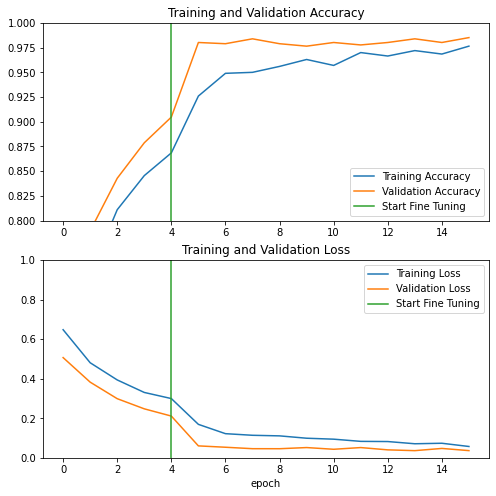

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluate the model on the test set

In [20]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 3s 484ms/step - loss: 0.0315 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Inference logic to interpret result from the model given an image

Predictions:
 [1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0]
Labels:
 [1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0]


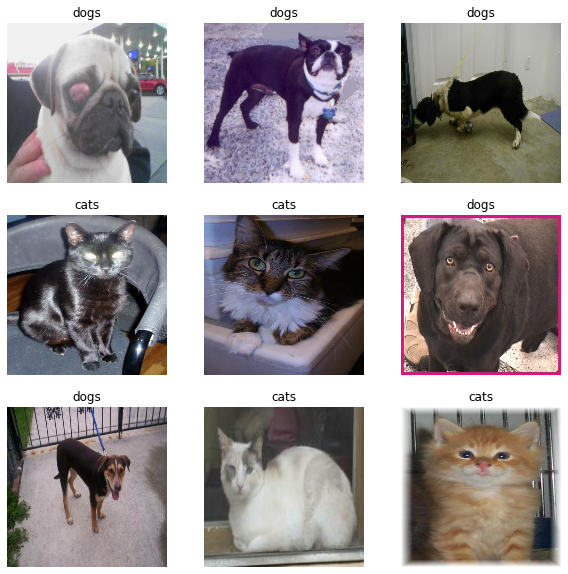

In [21]:
# Apply a sigmoid since our model returns logits
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Summary and Key Takeaways
1. From the notebook we learn how to perform transfer learning on custom dataset
2. Add remove layers and customize the model architecture
3. Plot graphs and interpret the training results
4. Interpret output results given an image

